In [63]:
import gym
import numpy as np, pandas as pd
env = gym.make('Taxi-v2')
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [64]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print('n_states = %i,n_actions=%i'%(n_states,n_actions))

n_states = 500,n_actions=6


In [65]:
policy = np.full((n_states,n_actions),1./n_actions)

In [66]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy, axis=1),1)

In [67]:
s =env.reset()

In [68]:
policy[s]

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [69]:
def generate_session(policy,t_max=10**4):
    states,actions=[],[]
    total_reward=0.
    s =env.reset()
    for t in range(t_max):
        a = np.random.choice(np.arange(n_actions),p=policy[s])
        new_s,r,done,info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

In [70]:
s,a,r = generate_session(policy)
assert type(s)==type(a)==list
assert len(s)==len(a)
assert type(r) in [float,np.float]

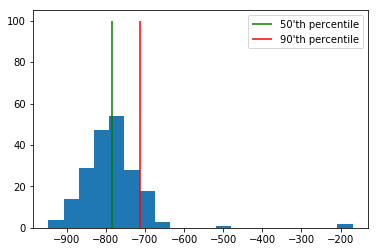

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

In [72]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold=np.percentile(rewards_batch,percentile)
    indexes = [index for index,value in enumerate(rewards_batch) if value >= reward_threshold]
    elite_states = [states_batch[i] for i in indexes]
    elite_actions = [actions_batch[i] for i in indexes]
    elite_states_flat = [batch for sublist in elite_states for batch in sublist]
    elite_actions_flat = [batch for sublist in elite_actions for batch in sublist]
    return elite_states_flat, elite_actions_flat

In [73]:
def update_policy(elite_states,elite_actions):
    new_policy = np.zeros([n_states,n_actions])
    occurences = {}
    
    for idx in range(n_states):
        occurences[idx] = 0
      
    for index,state in enumerate(elite_states):
        new_policy[state,elite_actions[index]] += 1 
        occurences[state] += 1
        
    for idx in range(n_states):
        if occurences[idx] == 0:
            new_policy[idx,:] = 1./n_actions
        else:
            new_policy[idx,:] /= occurences[idx]
    return new_policy

In [74]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [75]:
policy = np.ones([n_states,n_actions])/n_actions 

mean reward = -25.628, threshold=6.000


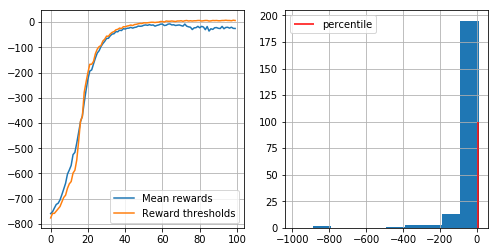

In [76]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    
    #display results on chart
    show_progress(batch_rewards, log, percentile)

In [77]:
env = gym.make('CartPole-v0').env

In [78]:
env.reset()

array([ 0.03994111, -0.04571375, -0.02235443,  0.02513418])

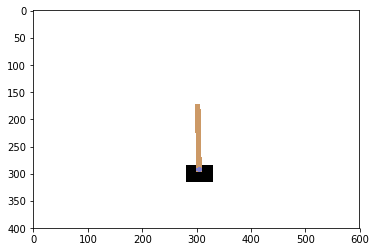

In [79]:
n_actions=env.action_space.n
plt.imshow(env.render('rgb_array'))

In [80]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                     activation='tanh',
                     warm_start=True,
                     max_iter=1
                     )
agent.fit([env.reset()]*n_actions,range(n_actions))

c:\users\yingg\desktop\myproject0\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [83]:
def generate_session(t_max=1000):
    states,actions=[],[]
    total_reward = 0
    s = env.reset() 
    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(np.arange(n_actions),p=probs)
        new_s,r,done,info=env.step(a)
        states.append(s)
        actions.append(a)
        total_reward+=r
        s=new_s
        if done:
            break
    return states,actions,total_reward

mean reward = 717.730, threshold=1000.000


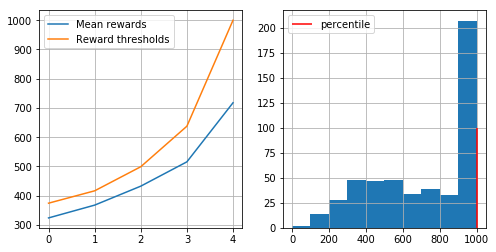

[1000.  663.  174.  323.  826. 1000. 1000.  846.  679.  904.  954. 1000.
 1000. 1000.  798.  578.  291. 1000.  854. 1000.  405. 1000.  311. 1000.
 1000. 1000.  863. 1000. 1000. 1000.  315.  490. 1000.  765.  446.  400.
  742.  610. 1000.  734.  368. 1000. 1000.  362.  342. 1000.  895.  886.
  955.  623.  930.  326.  143.  728.  555.  321.  258.  936.  377.  523.
  891.  911.  349.  450.  965. 1000.  510.  623. 1000.  751.  293.  370.
  417.  851. 1000.  583. 1000. 1000.  309. 1000.  311.  567.  570.  574.
  317.  600. 1000. 1000. 1000.  687. 1000. 1000.  768.  472. 1000.  524.
  750.  363. 1000. 1000.  549.  306.  574.  767.  402.  353.  729. 1000.
 1000.  718.  461.  281.  850. 1000. 1000.  480.  548.  455.  873. 1000.
  793. 1000.  847.  502.  941. 1000.  979.  925.  623.  424.  620.  387.
  588.  795. 1000. 1000. 1000.  822. 1000.  710. 1000.  559.  214.  663.
  482.  595.  382.  874. 1000.  861.  549.  955.  531. 1000. 1000.  265.
  457. 1000. 1000.  993.  399.  523.  667. 1000.  4

KeyboardInterrupt: 

In [84]:
n_sessions = 500
percentile = 70
log =[]
for i in range(100):
    sessions = [generate_session() for _ in range(n_sessions)]
    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    elite_states,elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)
    agent.fit(elite_states,elite_actions)
    show_progress(batch_rewards,log,percentile,reward_range=[0,np.max(batch_rewards)])
    print(batch_rewards)
    if np.mean(batch_rewards)>190:
        print("You win!You may stop training now via keyboard interrupt.")